In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import scipy as sp
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split,KFold,RandomizedSearchCV,GridSearchCV,cross_val_score,ShuffleSplit
from sklearn.linear_model import LogisticRegression,Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.metrics import average_precision_score, accuracy_score, recall_score
from itertools import chain, combinations
from sklearn import model_selection

In [9]:
df = pd.read_csv("/Users/oscarengelbrektson/Downloads/facebook_train.csv")

In [10]:
pp.ProfileReport(df)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,10
Number of observations,397
Total Missing (%),0.0%
Total size in memory,31.1 KiB
Average record size in memory,80.3 B
Numeric,6
Categorical,1
Boolean,1
Date,0
Text (Unique),0
Rejected,2


# Pre-processing

In [11]:
#Strongly skewed distribution, log transform. 1p to avoid 0 problems
df["log_like"] = np.log1p(df["like"])

df["log_like"].hist()
plt.show()

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  """


In [12]:
#Convert onordered categorical variable to 3 binary variables
df["photo"] = [1 if x=="Photo" else 0 for x in df["type"]]
df["status"] = [1 if x=="Status" else 0 for x in df["type"]]
df["link"] = [1 if x=="Link" else 0 for x in df["type"]]


#Convert onordered categorical variable to 3 binary variables
df["cat2"] = [1 if x==2 else 0 for x in df["category"]]
df["cat3"] = [1 if x==3 else 0 for x in df["category"]]

In [13]:
df.head()

,total_followers,type,category,month,weekday,hour,paid,comment,like,share,log_like,photo,status,link,cat2,cat3
0,124050,Photo,3,6,4,17,1,3,77,16,4.356709,1,0,0,0,1
1,132556,Photo,2,8,3,24,0,11,313,50,5.749393,1,0,0,1,0
2,92786,Photo,2,2,6,17,1,2,145,39,4.983607,1,0,0,1,0
3,135632,Photo,1,9,2,1,0,2,299,49,5.703782,1,0,0,0,0
4,139540,Link,1,12,3,17,1,7,229,21,5.438079,0,0,1,0,0


In [14]:
#Two possible models: one with log transform of like, one without.
y = df["comment"]
y1 = df["log_like"]

#Excluding month because of 0.93 R^2 with total_followers
X = df[["total_followers", "weekday", "hour", "paid", "photo", "status", "link", "cat2", "cat3"]]

# Developing a model

In [39]:
model = LinearRegression()

scoring = ["neg_mean_squared_error", "neg_mean_absolute_error", "neg_median_absolute_error"]

cv_results1 = cross_validate(model, X, y,
                            scoring=scoring, cv=5)

cv_results2 = cross_validate(model, X, y1,
                            scoring=scoring, cv=5)

In [40]:
for model in [cv_results1,cv_results2]:
    print("\n")
    for metric in model.keys():
        print(metric, np.mean(model[metric]))



fit_time 0.0029902935028076174
score_time 0.004542684555053711
test_neg_mean_squared_error -818.6784949760975
test_neg_mean_absolute_error -10.990846415441691
test_neg_median_absolute_error -6.742031269678003


fit_time 0.003240633010864258
score_time 0.004168081283569336
test_neg_mean_squared_error -1.3768216545089913
test_neg_mean_absolute_error -0.8547306014608005
test_neg_median_absolute_error -0.6163727174922148


### The second model performs much better




-

# Casualty data set

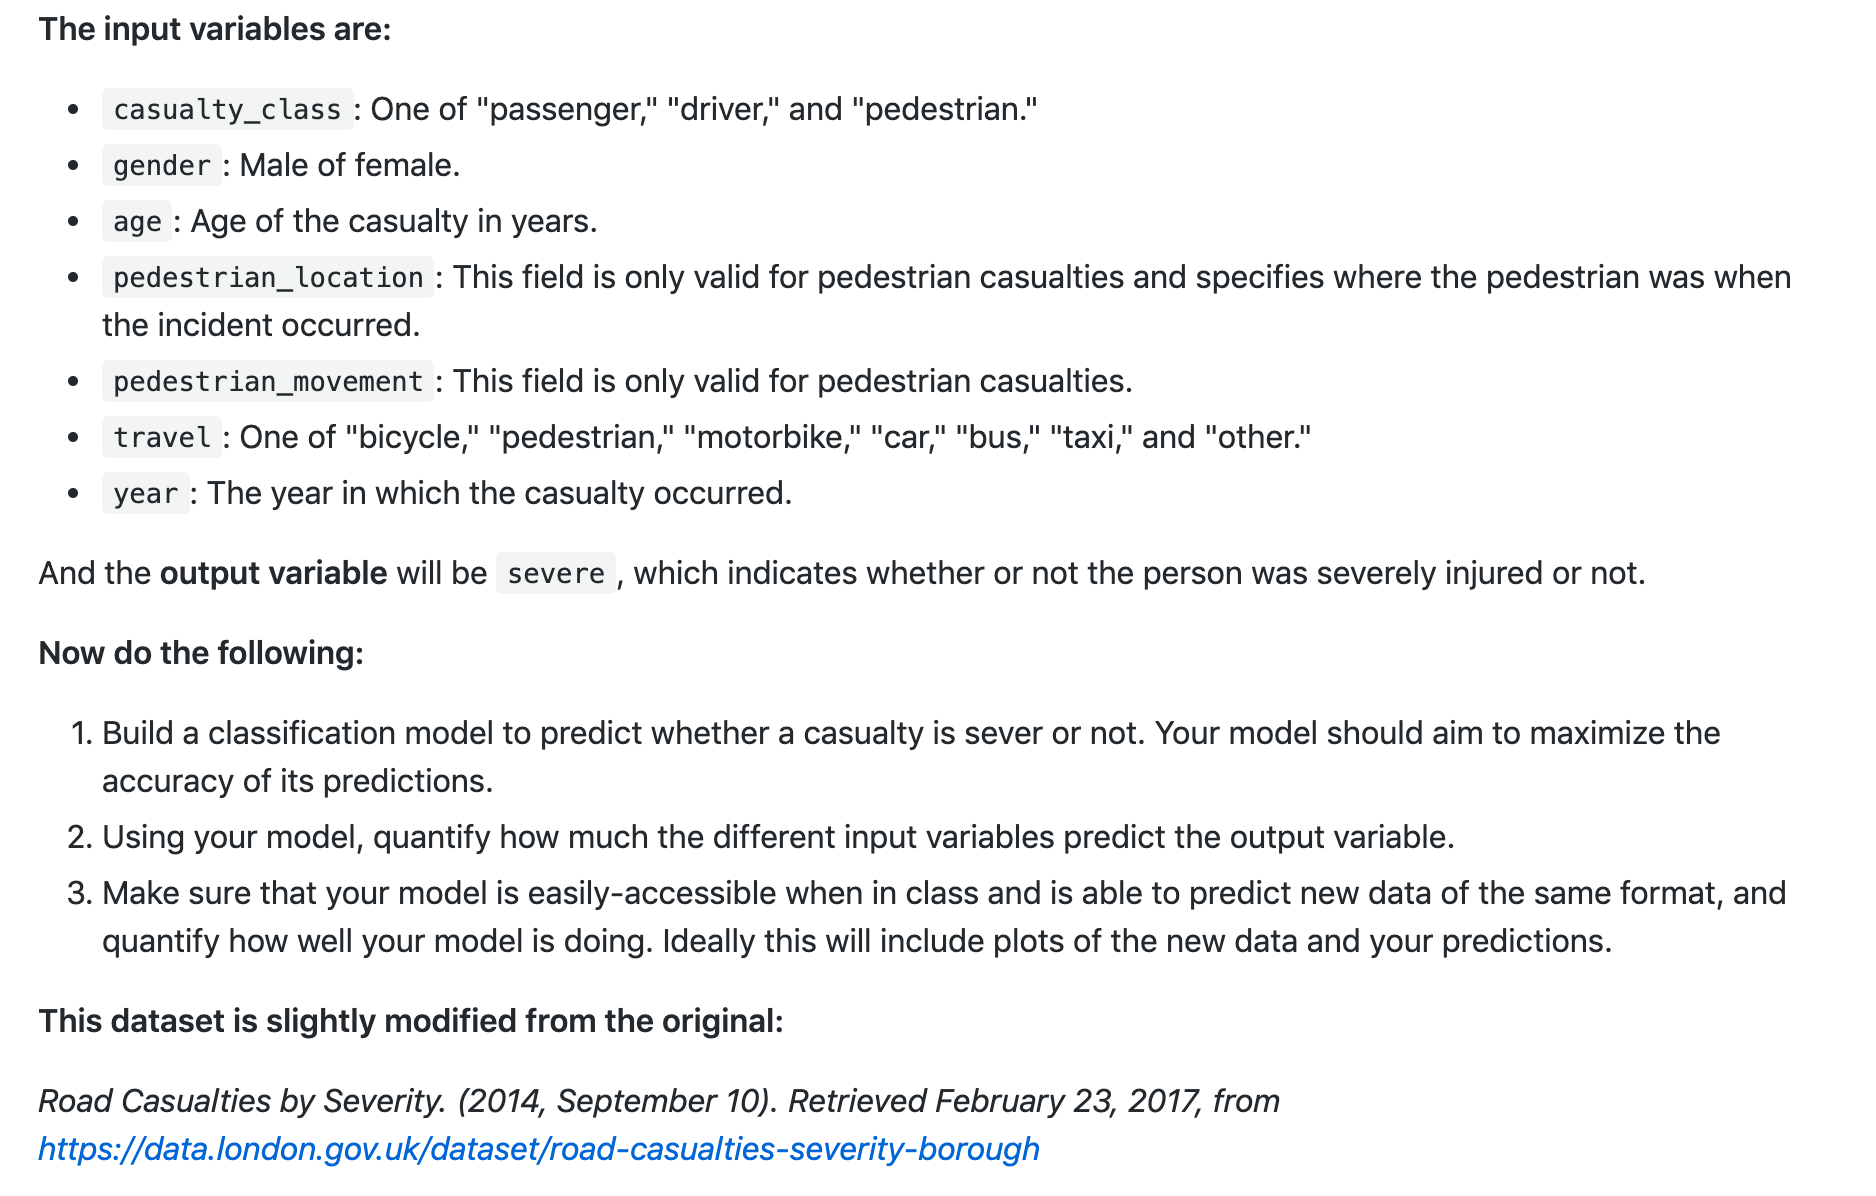

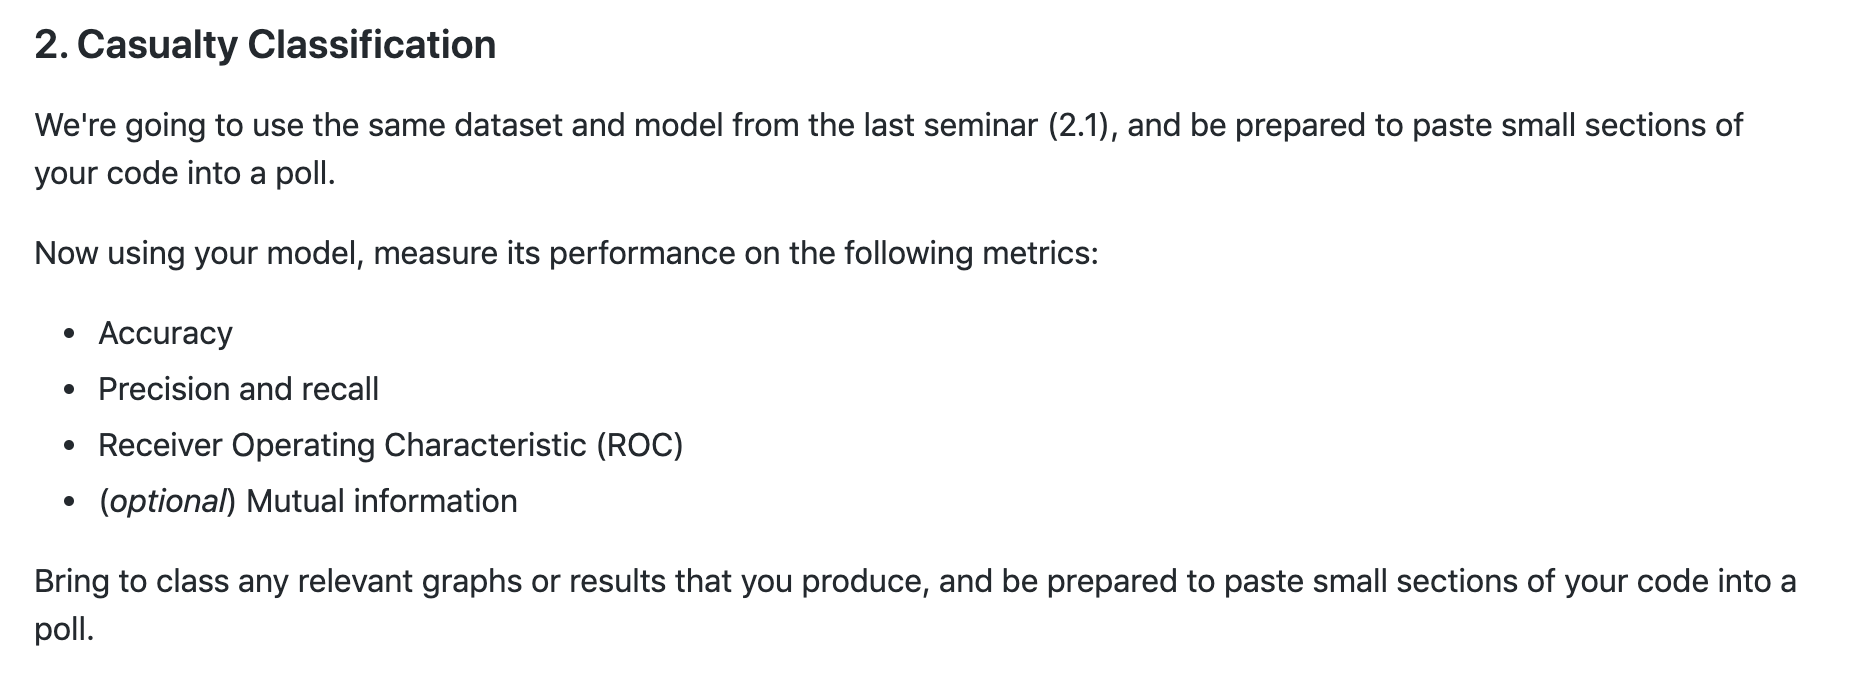

In [101]:
df = pd.read_csv("/Users/oscarengelbrektson/Downloads/casualty_train.csv")

In [91]:
pp.ProfileReport(df)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,8
Number of observations,232835
Total Missing (%),20.4%
Total size in memory,12.7 MiB
Average record size in memory,57.0 B
Numeric,1
Categorical,6
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [104]:
#Dummy for gender
df["female"] = [1 if x=="female" else 0 for x in df["gender"]]

#dummies for causualty_class
df["passenger"] = [1 if x=="passenger" else 0 for x in df["casualty_class"]]
df["pedestrian"] = [1 if x=="pedestrian" else 0 for x in df["casualty_class"]]
df["driver"] = [1 if x=="driver" else 0 for x in df["casualty_class"]]

#dummy for severe
df["severe"] = [1 if x==True else 0 for x in df["severe"]]

#dummy for pedestrian_location
one_hot = pd.get_dummies(df['pedestrian_location'])
df = df.join(one_hot)

#dummy for pedestrian_movement
one_hot = pd.get_dummies(df['pedestrian_movement'])
df = df.join(one_hot)

#Impute average age for unkown age
#df['age'].fillna((df['age'].mean()), inplace=True)
df["age"] = df["age"].replace("Unknown", None)
df["age"] = pd.to_numeric(df["age"])
df["age"] = df['age'].fillna((df['age'].mean()), inplace=True)

#dummy for travel
#one_hot = pd.get_dummies(df['travel'])
#df = df.join(one_hot)

In [87]:
pp.ProfileReport(X)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,20
Number of observations,232835
Total Missing (%),0.0%
Total size in memory,13.8 MiB
Average record size in memory,62.0 B
Numeric,1
Categorical,1
Boolean,18
Date,0
Text (Unique),0
Rejected,0


In [105]:
X = df.drop(["casualty_class","gender", "severe", "pedestrian_location", "pedestrian_movement", "Unknown Or Other", "Unknown", "travel"], axis=1)
y = df["severe"]

In [133]:
model = LogisticRegression()

scoring = ["recall", "precision", 'roc_auc', 'accuracy', 'mutual_info_score', 'r2']

cv_results1 = cross_validate(model, X, y,
                            scoring=scoring, cv=5)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/oscarengelbrektson/anaconda/lib/python3.6/s

In [134]:
for model in [cv_results1]:
    print("\n")
    for metric in model.keys():
        print(metric, np.mean(model[metric]))



fit_time 0.9178514003753662
score_time 0.11406459808349609
test_recall 0.0
test_precision 0.0
test_roc_auc 0.6636653693990878
test_accuracy 0.8923701333562393
test_mutual_info_score 0.0
test_r2 -0.12061123811815659


In [20]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [129]:
data = pd.read_csv("/Users/oscarengelbrektson/Downloads/casualty_train.csv")

In [130]:
data = pd.get_dummies(data, columns=['casualty_class', 'travel', 'pedestrian_movement'])
data['severe'] = data['severe'].astype('category')
data['gender'] = data['gender'].astype('category')

cat_columns = data.select_dtypes(['category']).columns
data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)

data['age'] = data.apply(lambda x: x['age'] if x['age'] != 'Unknown' else '-1', axis = 1)
data['age'] = data['age'].astype('int')
data['age'] = data['age'].replace(-1, data['age'].mean())

y = data['severe']
X = data.drop(['severe', 'pedestrian_location', 'year'], axis = 1)

In [131]:
model = LogisticRegression()

scoring = ["recall", "precision", 'roc_auc', 'accuracy', 'mutual_info_score']

cv_results1 = cross_validate(model, X, y,
                            scoring=scoring, cv=5)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/oscarengelbrektson/anaconda/lib/python3.6/s

In [132]:
for model in [cv_results1]:
    print("\n")
    for metric in model.keys():
        print(metric, np.mean(model[metric]))



fit_time 0.7309032440185547
score_time 0.09499592781066894
test_recall 0.0
test_precision 0.0
test_roc_auc 0.6636653693990878
test_accuracy 0.8923701333562393
test_mutual_info_score 0.0


In [123]:
model["test_precision"]

array([0., 0., 0., 0., 0.])